# A cube under pressure on a part of its face

### Units
- Length: mm
- Mass: kg
- Time:  s
- Force: milliNewtons
- Stress: kPa 

### Software:
- Dolfinx v0.8.0


Accompanies the book, 
- L. Anand, E.M. Stewart, S.A. Chester. _Introduction to coupled theories in solid mechanics_. 2025, in preparation.


# Import modules

In [1]:
# Import FEnicSx/dolfinx
import dolfinx

# For numerical arrays
import numpy as np

# For MPI-based parallelization
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

# PETSc solvers
from petsc4py import PETSc

# specific functions from dolfinx modules
from dolfinx import fem, mesh, io, plot, log
from dolfinx.fem import (Constant, dirichletbc, Function, functionspace, Expression )
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver
from dolfinx.io import VTXWriter, XDMFFile


# specific functions from ufl modules
import ufl
from ufl import (TestFunctions, TrialFunction, Identity, grad, det, div, dev, inv, tr, sqrt, conditional ,\
                 gt, dx, inner, derivative, dot, ln, split)

# basix finite elements (necessary for dolfinx v0.8.0)
import basix
from basix.ufl import element, mixed_element, quadrature_element

# Matplotlib for plotting
import matplotlib.pyplot as plt
plt.close('all')

# For timing the code
from datetime import datetime


# Set level of detail for log messages (integer)
# Guide:
# CRITICAL  = 50, // errors that may lead to data corruption
# ERROR     = 40, // things that HAVE gone wrong
# WARNING   = 30, // things that MAY go wrong later
# INFO      = 20, // information of general interest (includes solver info)
# PROGRESS  = 16, // what's happening (broadly)
# TRACE     = 13, // what's happening (in detail)
# DBG       = 10  // sundry
#
log.set_log_level(log.LogLevel.WARNING)

# Define geometry

In [2]:
# A 3-D cube
length = 50.0 # mm
domain = mesh.create_box(MPI.COMM_WORLD, [[0.0,0.0,0.0], [length,length,length]],\
                         [10,10,6], mesh.CellType.tetrahedron)

x = ufl.SpatialCoordinate(domain)

**Identify boundaries of the domain**

In [3]:
# Identify the planar boundaries of the  box mesh
def xBot(x):
    return np.isclose(x[0], 0)
def xTop(x):
    return np.isclose(x[0], length)
def yBot(x):
    return np.isclose(x[1], 0)
def yTop(x):
    return np.isclose(x[1], length)
def zBot(x):
    return np.isclose(x[2], 0)
def loadFace(x):
    return  np.logical_and(np.logical_and(np.isclose(x[2],length) , np.less_equal(x[0],length/2)) , np.less_equal(x[1], length/2))
def zTop(x):
    return np.logical_and(np.isclose(x[2], length),np.logical_not(loadFace(x)))

# Mark the sub-domains
boundaries = [(1,xBot),(2,xTop),(3,yBot),(4,yTop),(5,zBot),(6,loadFace),(7,zTop)]

# build collections of facets on each subdomain and mark them appropriately.
facet_indices, facet_markers = [], [] # initalize empty collections of indices and markers.
fdim = domain.topology.dim - 1 # geometric dimension of the facet (mesh dimension - 1)
for (marker, locator) in boundaries:
    facets = mesh.locate_entities(domain, fdim, locator) # an array of all the facets in a 
                                                         # given subdomain ("locator")
    facet_indices.append(facets)                         # add these facets to the collection.
    facet_markers.append(np.full_like(facets, marker))   # mark them with the appropriate index.

# Format the facet indices and markers as required for use in dolfinx.
facet_indices = np.hstack(facet_indices).astype(np.int32)
facet_markers = np.hstack(facet_markers).astype(np.int32)
sorted_facets = np.argsort(facet_indices)
# 
# Add these marked facets as "mesh tags" for later use in BCs.
facet_tags = mesh.meshtags(domain, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets])

**Print out the unique facet index numbers**

In [4]:
top_imap = domain.topology.index_map(2)      # index map of 2D entities in domain (facets)
values = np.zeros(top_imap.size_global)      # an array of zeros of the same size as number of 2D entities
values[facet_tags.indices]=facet_tags.values # populating the array with facet tag index numbers
print(np.unique(facet_tags.values))          # printing the unique indices

# Surface numbering:
# boundaries = [(1,xBot),(2,xTop),(3,yBot),(4,yTop),(5,zBot),(6,loadFace),(7,zTop)]

[1 2 3 4 5 6 7]


**Visualize reference configuration and boundary facets**

In [5]:
import pyvista
pyvista.set_jupyter_backend('html')
from dolfinx.plot import vtk_mesh
pyvista.start_xvfb()

# initialize a plotter
plotter = pyvista.Plotter()

# Add the mesh -- I make the 3D mesh opaque, so that 2D surfaces stand out.
topology, cell_types, geometry = plot.vtk_mesh(domain, domain.topology.dim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
plotter.add_mesh(grid, show_edges=True, opacity=0.25) 

# Add colored 2D surfaces for the named surfaces
xBot_surf = pyvista.UnstructuredGrid(*vtk_mesh(domain, domain.topology.dim-1,facet_tags.indices[facet_tags.values==1]) )
yBot_surf = pyvista.UnstructuredGrid(*vtk_mesh(domain, domain.topology.dim-1,facet_tags.indices[facet_tags.values==3]) )
zBot_surf = pyvista.UnstructuredGrid(*vtk_mesh(domain, domain.topology.dim-1,facet_tags.indices[facet_tags.values==5]) )
load_surf = pyvista.UnstructuredGrid(*vtk_mesh(domain, domain.topology.dim-1,facet_tags.indices[facet_tags.values==6]) )
#
actor = plotter.add_mesh(xBot_surf, show_edges=True,color="blue") # xBot face is blue
actor2 = plotter.add_mesh(yBot_surf, show_edges=True,color="red") # yBot is red
actor3 = plotter.add_mesh(zBot_surf, show_edges=True,color="green") # zBot is green
actor4 = plotter.add_mesh(load_surf, show_edges=True,color="yellow") # Loaded surface is yellow

labels = dict(zlabel='Z', xlabel='X', ylabel='Y')
plotter.add_axes(**labels)

if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    plotter.screenshot("mesh.png")

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

## Define boundary and volume integration measure

In [6]:
# Define the boundary integration measure "ds" using the facet tags,
# also specify the number of surface quadrature points.
ds = ufl.Measure('ds', domain=domain, subdomain_data=facet_tags, metadata={'quadrature_degree':4})

# Define the volume integration measure "dx" 
# also specify the number of volume quadrature points.
dx = ufl.Measure('dx', domain=domain, metadata={'quadrature_degree': 4})

#  Define facet normal
n = ufl.FacetNormal(domain)

# Material parameters
-Arruda-Boyce model

In [7]:
Gshear_0 = Constant(domain,PETSc.ScalarType(280.0))            # Ground state shear modulus
lambdaL  = Constant(domain,PETSc.ScalarType(5.12))             # Locking stretch
Kbulk    = Constant(domain,PETSc.ScalarType(1000.0*Gshear_0)) 

# Simulation time-control related params

In [8]:
# Simulation time control-related params
t    = 0.0          # start time
Ttot = 30           # total simulation time 
press_max = 1.5e3    # final pressure (kPa)
numSteps = 100
dt = Ttot/numSteps  #  fixed step size

# Function to linearly ramp up pressure on boundary.
def pressRamp(t):
    return press_max*t/Ttot

# Function spaces

In [9]:
# Define function space, both vectorial and scalar
# dolfinx v0.8.0 syntax:   
U2 = element("Lagrange", domain.basix_cell(), 2, shape=(3,)) # For displacement
P1 = element("Lagrange", domain.basix_cell(), 1)  # For  pressure                                         
#
TH = mixed_element([U2, P1])     # Taylor-Hood style mixed element
ME = functionspace(domain, TH)    # Total space for all DOFs

# Define actual functions with the required DOFs
w    = Function(ME)
u, p = split(w)  # displacement u, pressure p

# A copy of functions to store values in the previous step
w_old         = Function(ME)
u_old,  p_old = split(w_old)   

# Define test functions        
u_test, p_test = TestFunctions(ME)    

# Define trial functions needed for automatic differentiation
dw = TrialFunction(ME)                  

# Subroutines for kinematics and constitutive equations

In [10]:
# Deformation gradient 
def F_calc(u):
    Id = Identity(3) 
    F  = Id + grad(u)
    return F

def lambdaBar_calc(u):
    F = F_calc(u)
    C = F.T*F
    Cdis = J**(-2/3)*C
    I1 = tr(Cdis)
    lambdaBar = sqrt(I1/3.0)
    return lambdaBar

def zeta_calc(u):
    lambdaBar = lambdaBar_calc(u)
    # Use Pade approximation of Langevin inverse
    z    = lambdaBar/lambdaL
    z    = conditional(gt(z,0.95), 0.95, z) # Keep simulation from blowing up
    beta = z*(3.0 - z**2.0)/(1.0 - z**2.0)
    zeta = (lambdaL/(3*lambdaBar))*beta
    return zeta

# Generalized shear modulus for Arruda-Boyce model
def Gshear_AB_calc(u):
    zeta    = zeta_calc(u)
    Gshear  = Gshear_0 * zeta
    return Gshear

#---------------------------------------------
# Subroutine for calculating the Cauchy stress
#---------------------------------------------
def T_calc(u,p):
    Id = Identity(3) 
    F   = F_calc(u)
    J = det(F)
    B = F*F.T
    Bdis = J**(-2/3)*B
    Gshear  = Gshear_AB_calc(u)
    T = (1/J)* Gshear * dev(Bdis) - p * Id
    return T

#----------------------------------------------
# Subroutine for calculating the Piola  stress
#----------------------------------------------
def Piola_calc(u, p):
    Id = Identity(3) 
    F   = F_calc(u)
    J = det(F)
    #
    T   = T_calc(u,p)
    #
    Tmat   = J * T * inv(F.T)
    return Tmat

# Evaluate kinematics and constitutive relations

In [11]:
F =  F_calc(u)  
J = det(F)
lambdaBar = lambdaBar_calc(u)

# Piola stress
Tmat = Piola_calc(u, p)

# Weak forms

In [12]:
# Residuals:
# Res_0: Balance of forces (test fxn: u)
# Res_1: Coupling pressure (test fxn: p)

# Surface numbering:
# boundaries = [(1,xBot),(2,xTop),(3,yBot),(4,yTop),(5,zBot),(6,loadFace),(7,zTop)]

# Cofactor of F
Fcof = J*inv(F.T)

# Create a constant for the pressure value
pressRampCons = Constant(domain,PETSc.ScalarType(pressRamp(0)))

# Configuration-dependent traction
traction = - pressRampCons*dot(Fcof,n)

# The weak form for the balance of forces
Res_0 =  inner(Tmat, grad(u_test) )*dx - dot(traction, u_test)*ds(6) 

# The weak form for the pressure
fac_p = ln(J)/J
#
Res_1 = dot( (p/Kbulk + fac_p), p_test)*dx

# Total weak form
Res = Res_0 +  Res_1 

# Automatic differentiation tangent:
a = derivative(Res, w, dw)

# Set-up output files

In [13]:
# results file name
results_name = "3D_cube_footing"

# Function space for projection of results
# v0.8.0 syntax:
U1 = element("DG", domain.basix_cell(), 1, shape=(3,)) # For displacement
P0 = element("DG", domain.basix_cell(), 1)             # For  pressure  

V2 = fem.functionspace(domain, U1) #Vector function space
V1 = fem.functionspace(domain, P0) #Scalar function space

# fields to write to output file
u_vis = Function(V2)
u_vis.name = "disp"

p_vis = Function(V1)
p_vis.name = "p"

J_vis = Function(V1)
J_vis.name = "J"
J_expr = Expression(J,V1.element.interpolation_points())

lambdaBar_vis = Function(V1)
lambdaBar_vis.name = "lambdaBar"
lambdaBar_expr = Expression(lambdaBar,V1.element.interpolation_points())

P11 = Function(V1)
P11.name = "P11"
P11_expr = Expression(Tmat[0,0],V1.element.interpolation_points())
P22 = Function(V1)
P22.name = "P22"
P22_expr = Expression(Tmat[1,1],V1.element.interpolation_points())
P33 = Function(V1)
P33.name = "P33"
P33_expr = Expression(Tmat[2,2],V1.element.interpolation_points())

T   = Tmat*F.T/J
T0   = T - (1/3)*tr(T)*Identity(3)
Mises = sqrt((3/2)*inner(T0, T0))
Mises_vis= Function(V1,name="Mises")
Mises_expr = Expression(Mises,V1.element.interpolation_points())

# set up the output VTX files.
file_results = VTXWriter(
    MPI.COMM_WORLD,
    "results/" + results_name + ".bp",
    [  # put the functions here you wish to write to output
        u_vis, p_vis, J_vis, P11, P22, P33, lambdaBar_vis,
        Mises_vis,
    ],
    engine="BP4",
)

def writeResults(t):
       # Output field interpolation 
       u_vis.interpolate(w.sub(0))
       p_vis.interpolate(w.sub(1))
       J_vis.interpolate(J_expr)
       P11.interpolate(P11_expr)
       P22.interpolate(P22_expr)
       P33.interpolate(P33_expr)
       lambdaBar_vis.interpolate(lambdaBar_expr)
       Mises_vis.interpolate(Mises_expr)
       
       # Write output fields
       file_results.write(t) 
        

# Infrastructure for pulling out time history data (force, displacement, etc.)

In [14]:

# infrastructure for evaluating functions at a certain point efficiently
pointForDisp = np.array([0, 0, length])
bb_tree = dolfinx.geometry.bb_tree(domain,domain.topology.dim)
cell_candidates = dolfinx.geometry.compute_collisions_points(bb_tree, pointForDisp)
colliding_cells = dolfinx.geometry.compute_colliding_cells(domain, cell_candidates, pointForDisp).array

# Start simulation

In [15]:
# Give the step a descriptive name
step = "Compress"

## Boundary condtions

In [16]:
# Surface numbering:
# boundaries = [(1,xBot),(2,xTop),(3,yBot),(4,yTop),(5,zBot),(6,loadFace),(7,zTop)]

# Find the specific DOFs which will be constrained.
xBtm_u1_dofs = fem.locate_dofs_topological(ME.sub(0).sub(0), facet_tags.dim, facet_tags.find(1))
yBtm_u2_dofs = fem.locate_dofs_topological(ME.sub(0).sub(1), facet_tags.dim, facet_tags.find(3))
zBtm_u3_dofs = fem.locate_dofs_topological(ME.sub(0).sub(2), facet_tags.dim, facet_tags.find(5))
#
load_u1_dofs = fem.locate_dofs_topological(ME.sub(0).sub(0), facet_tags.dim, facet_tags.find(6))
load_u2_dofs = fem.locate_dofs_topological(ME.sub(0).sub(1), facet_tags.dim, facet_tags.find(6))

# building Dirichlet BCs
bcs_1 = dirichletbc(0.0, xBtm_u1_dofs, ME.sub(0).sub(0))  # u1 fix - xBtm
bcs_2 = dirichletbc(0.0, yBtm_u2_dofs, ME.sub(0).sub(1))  # u2 fix - yBtm
bcs_3 = dirichletbc(0.0, zBtm_u3_dofs, ME.sub(0).sub(2))  # u3 fix - zBtm
#
bcs_4 = dirichletbc(0.0, load_u1_dofs, ME.sub(0).sub(0))  # u1 fix - xBtm
bcs_5 = dirichletbc(0.0, load_u2_dofs, ME.sub(0).sub(1))  # u2 fix - yBtm

bcs = [bcs_1, bcs_2, bcs_3, bcs_4, bcs_5]

## Define the nonlinear variational problem

In [17]:

# Set up nonlinear problem
problem = NonlinearProblem(Res, w, bcs, a)

# the global newton solver and params
solver = NewtonSolver(MPI.COMM_WORLD, problem)
solver.convergence_criterion = "incremental"
solver.rtol = 1e-8
solver.atol = 1e-8
solver.max_it = 50
solver.report = True

#  The Krylov solver parameters.
ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "preonly" # "preonly" works equally well
opts[f"{option_prefix}pc_type"] = "lu" # do not use 'gamg' pre-conditioner
opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
opts[f"{option_prefix}ksp_max_it"] = 30
ksp.setFromOptions()



##  Start calculation loop

In [18]:
# Variables for storing time history
totSteps = numSteps+1
timeHist0 = np.zeros(shape=[totSteps])
timeHist1 = np.zeros(shape=[totSteps]) 
timeHist2 = np.zeros(shape=[totSteps]) 

#Iinitialize a counter for reporting data
ii=0

# Write initial state to file
writeResults(t=0.0)    

# Print out message for simulation start
print("------------------------------------")
print("Simulation Start")
print("------------------------------------")
# Store start time 
startTime = datetime.now()

# Time-stepping solution procedure loop
while (round(t + dt, 9) <= Ttot):
     
    # increment time
    t += dt 
    # increment counter
    ii += 1
    
    # update time variables in time-dependent BCs 
    pressRampCons.value = pressRamp(t)
    
    # Solve the problem
    try:
        (iter, converged) = solver.solve(w)
    except: # Break the loop if solver fails
        print("Ended Early")
        break
    
    # Collect results from MPI ghost processes
    w.x.scatter_forward()
    
    # Write output to file
    writeResults(t)
    
    # Update DOFs for next step
    w_old.x.array[:] = w.x.array
   
    # Store time history variables at this time  
    timeHist0[ii] = t # current time
    #
    timeHist1[ii] =  pressRamp(t) # time history of applied pressure
    #
    timeHist2[ii] = w.sub(0).sub(2).eval([0.0, 0.0, length],colliding_cells[0])[0] # time history of displacement
    
    # Print progress of calculation
    if ii%1 == 0:      
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print("Step: {} | Increment: {}, Iterations: {}".\
              format(step, ii, iter))
        print("      Simulation Time: {} s  of  {} s".\
              format(round(t,4), Ttot))
        print() 
    

# close the output file.
file_results.close()
         
# End analysis
print("-----------------------------------------")
print("End computation")                 
# Report elapsed real time for the analysis
endTime = datetime.now()
elapseTime = endTime - startTime
print("------------------------------------------")
print("Elapsed real time:  {}".format(elapseTime))
print("------------------------------------------")


------------------------------------
Simulation Start
------------------------------------
Step: Compress | Increment: 1, Iterations: 4
      Simulation Time: 0.3 s  of  30 s

Step: Compress | Increment: 2, Iterations: 4
      Simulation Time: 0.6 s  of  30 s

Step: Compress | Increment: 3, Iterations: 4
      Simulation Time: 0.9 s  of  30 s

Step: Compress | Increment: 4, Iterations: 4
      Simulation Time: 1.2 s  of  30 s

Step: Compress | Increment: 5, Iterations: 4
      Simulation Time: 1.5 s  of  30 s

Step: Compress | Increment: 6, Iterations: 4
      Simulation Time: 1.8 s  of  30 s

Step: Compress | Increment: 7, Iterations: 4
      Simulation Time: 2.1 s  of  30 s

Step: Compress | Increment: 8, Iterations: 4
      Simulation Time: 2.4 s  of  30 s

Step: Compress | Increment: 9, Iterations: 4
      Simulation Time: 2.7 s  of  30 s

Step: Compress | Increment: 10, Iterations: 4
      Simulation Time: 3.0 s  of  30 s

Step: Compress | Increment: 11, Iterations: 4
      Simula

# Plot results

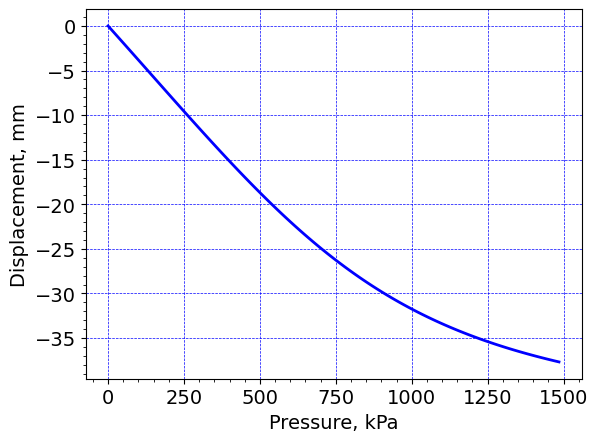

<Figure size 700x500 with 0 Axes>

In [19]:
# set plot font to size 14
font = {'size'   : 14}
plt.rc('font', **font)

# Get array of default plot colors
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# Only plot as far as we have time history data
ind = np.argmax(timeHist0)

# Vertical displacement  of center point on load surface:  
#
fig = plt.figure() 
#fig.set_size_inches(7,4)
ax=fig.gca()  
plt.plot(timeHist1[0:ind], timeHist2[0:ind], c='b',label='Simulation', linewidth=2.0)
#-------------------------------------------------------------
#ax.set.xlim(-0.01,0.01)
#ax.set.ylim(-0.03,0.03)
#plt.axis('tight')
plt.grid(linestyle="--", linewidth=0.5, color='b')
ax.set_xlabel(r'Pressure, kPa')              
ax.set_ylabel(r'Displacement, mm')
#ax.set_title("Displacement time curve", size=14, weight='normal')
from matplotlib.ticker import AutoMinorLocator,FormatStrFormatter
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
plt.show()

fig = plt.gcf()
fig.set_size_inches(7,5)
plt.tight_layout()
plt.savefig("results/3D_cube_footing.png", dpi=600)